## 1. Loop through images 
## 2. grab foregrounds
## 3. extract and compute SIFT feature descriptors
## 4. categorize into 2 classes based on given label
## 5. train SVC classifier with features and 2 labels
## 6. predict test image label with classifer

got features for 0.jpg
got features for 1.jpg
got features for 2.jpg
got features for 3.jpg
got features for 4.jpg
got features for 5.jpg
got features for 6.jpg
got features for 7.jpg
got features for 8.jpg
got features for 9.jpg
got features for 10.jpg
got features for 11.jpg
got features for 12.jpg
got features for 13.jpg
got features for 14.jpg
got features for 15.jpg
got features for 16.jpg
got features for 17.jpg
got features for 18.jpg
got features for 19.jpg
got features for 20.jpg
got features for 21.jpg
got features for 22.jpg
got features for 23.jpg
got features for 24.jpg
got features for 25.jpg
got features for 26.jpg
got features for 27.jpg
got features for 28.jpg
got features for 29.jpg
got features for 30.jpg
got features for 31.jpg
got features for 32.jpg
got features for 33.jpg
got features for 34.jpg
got features for 35.jpg
got features for 36.jpg
got features for 37.jpg
got features for 38.jpg
got features for 39.jpg
got features for 40.jpg
got features for 41.jpg
go

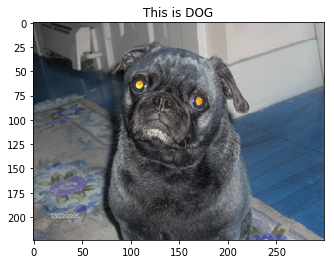

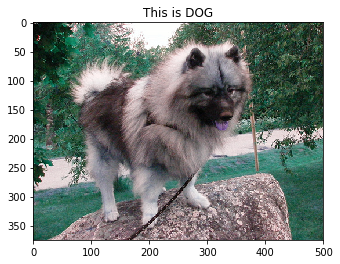

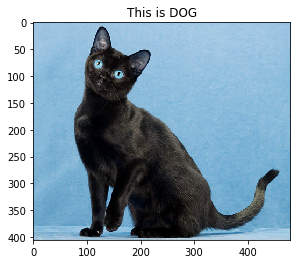

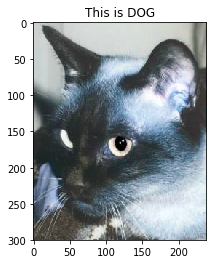

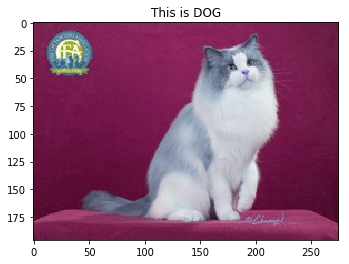

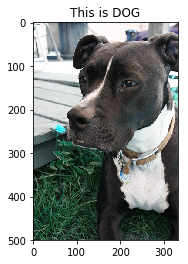

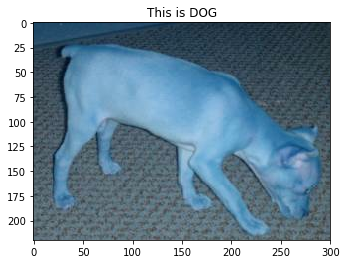

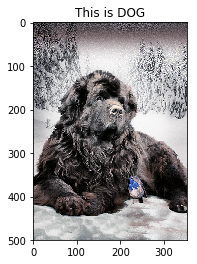

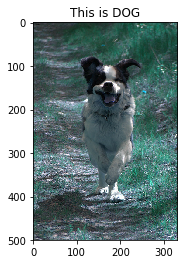

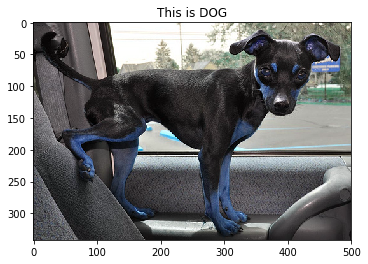

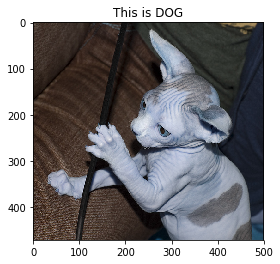

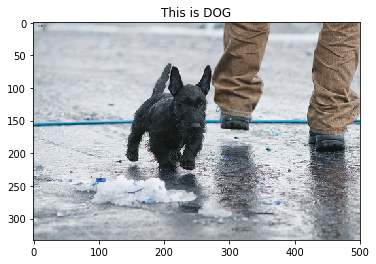

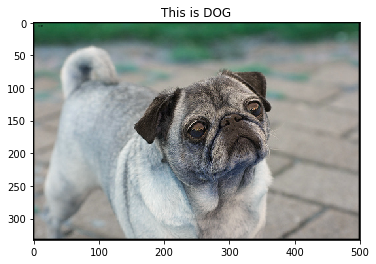

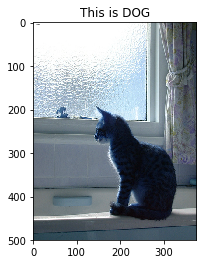

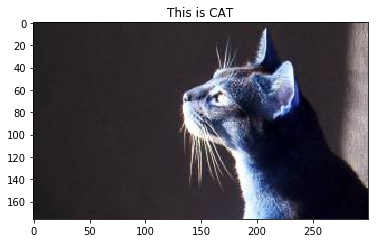

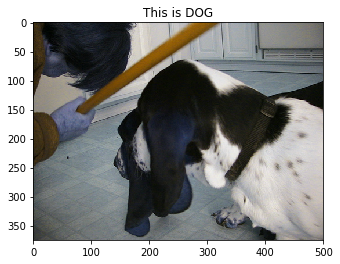

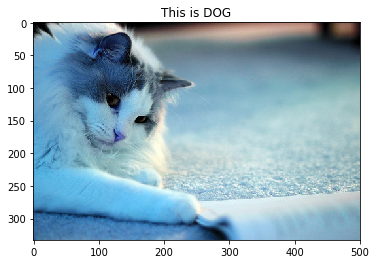

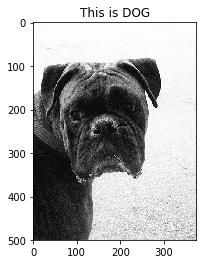

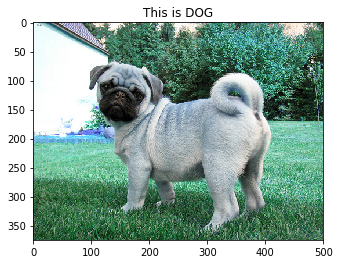

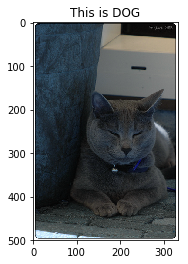

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import csv
from sklearn.svm import LinearSVC

sift = cv2.xfeatures2d.SIFT_create()  
flann_params = dict(algorithm = 1, trees = 5)     
matcher = cv2.FlannBasedMatcher(flann_params, {})
bow_extract  =cv2.BOWImgDescriptorExtractor(sift,matcher)

def grab(image):

    img = cv2.imread(image)
    
    mask = np.zeros(img.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    
    rect = (int(img.shape[0]*0.1),int(img.shape[1]*0.1),int(img.shape[0]*0.9),int(img.shape[1]*0.9))

    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,1,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    img = img*mask2[:,:,np.newaxis]
    
    return img

def trainVocab(descriptors):

#   change this to exceed the descriptor entry number by 2
    bow_train = cv2.BOWKMeansTrainer(20)
    
    for des in descriptors:
        bow_train.add(des)
        
    vocab = bow_train.cluster()
    bow_extract.setVocabulary(vocab)
    
    return vocab

def train(trainData, bow_extract, img, svmModel, dog):
    
    kp = sift.detect(img, None)
    
    # sort keypoints based on response
    kp = sorted(kp, key = lambda x:x.response)
    
    if(len(kp)>= 10):

        # compute descriptors for only the 10 keypoints with best responses for each image
        
        featureSet = bow_extract.compute(img, kp[:10])
        trainData.extend(featureSet)
        svmModel.append(dog)

    
def getFeatures(img, descriptors):
    sift = cv2.xfeatures2d.SIFT_create()
    # detect keypoints first
    kp = sift.detect(img,None)

    # sort keypoints based on response
    kp = sorted(kp, key = lambda x:x.response)
    
    if(len(kp)>= 10):

        # compute descriptors for only the 10 keypoints with best responses for each image
        kp, des = sift.compute(img, kp[:10])
    
        descriptors.extend(des)

def predict(voc, clf):

    bow_extract.setVocabulary(voc)

    testFolder = "X_Test/"

    for root, dirs, files in os.walk(testFolder):

        for file in files:
                
            result = "UNSURE"
            imgPath = (testFolder + file)
            img = grab(imgPath)
            original = cv2.imread(imgPath)
            featureset = bow_extract.compute(img, sift.detect(img))

            prediction = clf.predict(featureset)

            if (prediction == 1):

                result = "DOG"

            elif (prediction == 0):

                result = "CAT"
                    
            plt.imshow(original),plt.title("This is " + result),plt.show()


trainDir = 'X_Train/'
descriptors = []
trainData = []
svmModel = []
vocab = []
count = 1

for i in range (0,2):
    if (i == 0):
        with open('Y_Train.csv', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                    
                img = (trainDir + row['Image'])
                img = grab(img)
                
                getFeatures(img, descriptors)
                print("got features for " + row['Image'])
                count += 1
                
                #change this to test for smaller training set
                if count == 100:
                    break
                
        print("training vocab for " + str(count) + " images")
        vocab = trainVocab(descriptors)
        
    if (i == 1):
        count = 1        
        with open('Y_Train.csv', newline='') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                    
                img = (trainDir + row['Image'])
                dog = 0
                if (row['Label'] == '1'):
                    dog = 1
                img = grab(img)face
                count += 1
                
                print("training data with features of " + row['Image'])
                train(trainData, bow_extract, img, svmModel, dog)
                
                #change this to test for smaller training set
                if count == 100:
                    break
                
clf = LinearSVC()
clf.fit(trainData, svmModel)
predict(vocab, clf)
